# Import

In [1]:
import os
from datetime import datetime
from itertools import chain

import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import nibabel as nib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
from tensorboardX import SummaryWriter
summary = SummaryWriter(f'./tensorboard/{datetime.now().strftime("%Y-%m-%d_%H%M")}')

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# DataLoader

In [5]:
class MyDataset(Dataset):
    def __init__(self, test_size=0.2, test=False):
        
        data_files = glob('../../brainmask_nii/*.nii')
        data_files.sort()
        
        test_num = int(test_size * len(data_files))
        train_num = len(data_files) - test_num
        shuffled_index = np.random.permutation(len(data_files))
        
        train_fname = [data_files[i] for i in shuffled_index[:train_num]]
        test_fname  = [data_files[i] for i in shuffled_index[-test_num:]]
        
        label_file = pd.read_csv('../rsc/age_ixi_and_oasis.csv', index_col=0)
        
        if test:
            self.data_files = [data_files[i] for i in shuffled_index[-test_num:]]
            self.label_file = label_file.age_zscored.values[shuffled_index[-test_num:]]
            
        else:
            self.data_files = [data_files[i] for i in shuffled_index[:train_num]]
            self.label_file = label_file.age_zscored.values[shuffled_index[:train_num]]

    def __getitem__(self, idx):
        #print(idx)
        x = torch.tensor(nib.load(self.data_files[idx]).get_fdata())[None, :, :].float() / 255
        y = torch.tensor(self.label_file[idx]).float()
        return x, y

    def __len__(self):
        return len(self.data_files)

train_dset = MyDataset()
test_dset  = MyDataset(test=True)

train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

# 3D Convolution Model

## Modeling

In [6]:
class Conv3d(nn.Module):
    
    def __init__(self):
        super(Conv3d, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv3d(1, 8, 3, 3),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv3d(8, 16, 3, 3),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
                
        self.layer3 = nn.Sequential(
            nn.Conv3d(16, 32, 3, 3),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [7]:
model = Conv3d().float()
model.to(device)

Conv3d(
  (layer1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(3, 3, 3))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(3, 3, 3))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(3, 3, 3))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=32, o

## Debug

In [8]:
# with torch.no_grad():
#     for i, (x, y)in enumerate(test_loader):
#         if i < 1:
#             x = x.to(device)
#             y = y.to(device)
            
#             y_pred = model.forward(x).to(device)

#             loss = loss_fn(y_pred, y)
#             summary.add_scalar('loss/tst_loss', loss.item(), i)
#             summary.add_scalar('lr', lr, i)
#         else:
#             break

## Passing through Model

In [9]:
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
loss_fn = nn.MSELoss()

In [10]:
epochs = range(150)

trn_losses, tst_losses = [], []

for e in epochs:
    
    trn_bth_loss = 0
    model.train()
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x).to(device)
        
        loss = loss_fn(y_pred, y)
        del x, y, y_pred

        loss.backward()
        optimizer.step()

        trn_bth_loss += loss.item()
        
        if not i % 20:
            print(f'{i:<4}th Batch. Loss: {loss.item():.3f}')

    torch.cuda.empty_cache()
    trn_losses.append(trn_bth_loss / len(train_loader))
        
        
    tst_bth_loss = 0
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)

            y_pred = model.forward(x).to(device)
            loss = loss_fn(y_pred, y)
            del x, y, y_pred

            tst_bth_loss += loss.item()

    tst_losses.append(tst_bth_loss / len(test_loader))
    torch.cuda.empty_cache()
    
    summary.add_scalar('loss/training_loss', trn_losses[-1], e)
    summary.add_scalar('loss/validation_loss', tst_losses[-1], e)
    summary.add_scalars('loss/MSE_loss',
                        {'Train Loss': trn_losses[-1],
                         'Valid Loss': tst_losses[-1]}, e)
    summary.add_scalar('lr', lr, e)
    
    # Print
    print(f'EPOCHS {e} | TRAIN :: [LOSS] {trn_losses[-1]:.3f} | VALID :: [LOSS] {tst_losses[-1]:.3f}')

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0   th Batch. Loss: 0.488
20  th Batch. Loss: 1.124
40  th Batch. Loss: 1.184
60  th Batch. Loss: 0.501
80  th Batch. Loss: 1.073
100 th Batch. Loss: 0.763


C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


EPOCHS 0 | TRAIN :: [LOSS] 1.077 | VALID :: [LOSS] 1.064
0   th Batch. Loss: 0.316
20  th Batch. Loss: 1.156
40  th Batch. Loss: 1.255
60  th Batch. Loss: 0.654
80  th Batch. Loss: 1.008
100 th Batch. Loss: 0.731
EPOCHS 1 | TRAIN :: [LOSS] 1.010 | VALID :: [LOSS] 1.062
0   th Batch. Loss: 0.403
20  th Batch. Loss: 1.039
40  th Batch. Loss: 1.183
60  th Batch. Loss: 0.453
80  th Batch. Loss: 1.002
100 th Batch. Loss: 0.735
EPOCHS 2 | TRAIN :: [LOSS] 0.999 | VALID :: [LOSS] 1.064
0   th Batch. Loss: 0.359
20  th Batch. Loss: 1.056
40  th Batch. Loss: 1.293
60  th Batch. Loss: 0.536
80  th Batch. Loss: 0.993
100 th Batch. Loss: 0.736
EPOCHS 3 | TRAIN :: [LOSS] 0.992 | VALID :: [LOSS] 1.066
0   th Batch. Loss: 0.383
20  th Batch. Loss: 1.065
40  th Batch. Loss: 1.229
60  th Batch. Loss: 0.458
80  th Batch. Loss: 0.982
100 th Batch. Loss: 0.692
EPOCHS 4 | TRAIN :: [LOSS] 0.986 | VALID :: [LOSS] 1.065
0   th Batch. Loss: 0.378
20  th Batch. Loss: 1.040
40  th Batch. Loss: 1.236
60  th Batch.

20  th Batch. Loss: 0.965
40  th Batch. Loss: 1.134
60  th Batch. Loss: 0.323
80  th Batch. Loss: 0.978
100 th Batch. Loss: 0.706
EPOCHS 39 | TRAIN :: [LOSS] 0.935 | VALID :: [LOSS] 1.062
0   th Batch. Loss: 0.328
20  th Batch. Loss: 0.970
40  th Batch. Loss: 1.179
60  th Batch. Loss: 0.383
80  th Batch. Loss: 0.984
100 th Batch. Loss: 0.672
EPOCHS 40 | TRAIN :: [LOSS] 0.932 | VALID :: [LOSS] 1.058
0   th Batch. Loss: 0.343
20  th Batch. Loss: 0.979
40  th Batch. Loss: 1.177
60  th Batch. Loss: 0.330
80  th Batch. Loss: 0.975
100 th Batch. Loss: 0.682
EPOCHS 41 | TRAIN :: [LOSS] 0.930 | VALID :: [LOSS] 1.059
0   th Batch. Loss: 0.335
20  th Batch. Loss: 0.952
40  th Batch. Loss: 1.155
60  th Batch. Loss: 0.348
80  th Batch. Loss: 0.976
100 th Batch. Loss: 0.676
EPOCHS 42 | TRAIN :: [LOSS] 0.931 | VALID :: [LOSS] 1.061
0   th Batch. Loss: 0.325
20  th Batch. Loss: 0.935
40  th Batch. Loss: 1.175
60  th Batch. Loss: 0.328
80  th Batch. Loss: 0.970
100 th Batch. Loss: 0.687
EPOCHS 43 | TR

80  th Batch. Loss: 0.976
100 th Batch. Loss: 0.697
EPOCHS 77 | TRAIN :: [LOSS] 0.897 | VALID :: [LOSS] 1.063
0   th Batch. Loss: 0.316
20  th Batch. Loss: 0.925
40  th Batch. Loss: 1.118
60  th Batch. Loss: 0.330
80  th Batch. Loss: 0.971
100 th Batch. Loss: 0.625
EPOCHS 78 | TRAIN :: [LOSS] 0.895 | VALID :: [LOSS] 1.072
0   th Batch. Loss: 0.309
20  th Batch. Loss: 0.915
40  th Batch. Loss: 1.136
60  th Batch. Loss: 0.332
80  th Batch. Loss: 0.998
100 th Batch. Loss: 0.633
EPOCHS 79 | TRAIN :: [LOSS] 0.896 | VALID :: [LOSS] 1.067
0   th Batch. Loss: 0.344
20  th Batch. Loss: 0.946
40  th Batch. Loss: 1.097
60  th Batch. Loss: 0.319
80  th Batch. Loss: 0.991
100 th Batch. Loss: 0.641
EPOCHS 80 | TRAIN :: [LOSS] 0.900 | VALID :: [LOSS] 1.066
0   th Batch. Loss: 0.306
20  th Batch. Loss: 0.913
40  th Batch. Loss: 1.140
60  th Batch. Loss: 0.307
80  th Batch. Loss: 0.982
100 th Batch. Loss: 0.648
EPOCHS 81 | TRAIN :: [LOSS] 0.893 | VALID :: [LOSS] 1.070
0   th Batch. Loss: 0.341
20  th B

EPOCHS 115 | TRAIN :: [LOSS] 0.879 | VALID :: [LOSS] 1.071
0   th Batch. Loss: 0.321
20  th Batch. Loss: 0.909
40  th Batch. Loss: 1.114
60  th Batch. Loss: 0.327
80  th Batch. Loss: 1.018
100 th Batch. Loss: 0.626
EPOCHS 116 | TRAIN :: [LOSS] 0.882 | VALID :: [LOSS] 1.068
0   th Batch. Loss: 0.299
20  th Batch. Loss: 0.909
40  th Batch. Loss: 1.104
60  th Batch. Loss: 0.308
80  th Batch. Loss: 0.975
100 th Batch. Loss: 0.657
EPOCHS 117 | TRAIN :: [LOSS] 0.880 | VALID :: [LOSS] 1.068
0   th Batch. Loss: 0.298
20  th Batch. Loss: 0.915
40  th Batch. Loss: 1.100
60  th Batch. Loss: 0.313
80  th Batch. Loss: 0.986
100 th Batch. Loss: 0.636
EPOCHS 118 | TRAIN :: [LOSS] 0.876 | VALID :: [LOSS] 1.067
0   th Batch. Loss: 0.345
20  th Batch. Loss: 0.923
40  th Batch. Loss: 1.128
60  th Batch. Loss: 0.317
80  th Batch. Loss: 0.986
100 th Batch. Loss: 0.686
EPOCHS 119 | TRAIN :: [LOSS] 0.878 | VALID :: [LOSS] 1.069
0   th Batch. Loss: 0.303
20  th Batch. Loss: 0.930
40  th Batch. Loss: 1.090
60 

KeyboardInterrupt: 

# Plot Result

### Loss

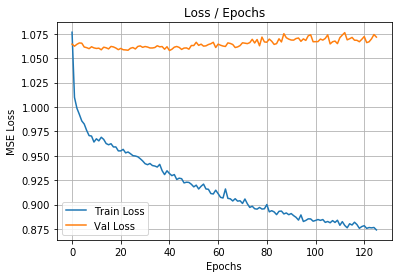

In [11]:
plt.plot(trn_losses)
plt.plot(tst_losses)
plt.legend(['Train Loss', 'Val Loss'])
plt.title('Loss / Epochs')
plt.xlabel('Epochs')
#plt.xticks(np.arange(0, 20, step=2), [x for x in np.arange(0, 20, step=2)])
plt.ylabel('MSE Loss')
plt.grid()
plt.show()

### Regression Accuracy

In [12]:
def plot_result(trues, preds, title='Train', fname=None):
    preds = np.array(list(chain(*preds)))
    trues = np.array(list(chain(*trues)))
    
    cut = max(max(abs(preds)), max(abs(trues)))
    cuts = [-cut, cut]
              
    plt.figure(figsize=(9, 9))
    plt.scatter(preds, trues)
    plt.xlim(*cuts)
    plt.ylim(*cuts)
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title(f'{title} Dataset Prediction')
    plt.grid()
    domain = np.linspace(*cuts, 100)
    plt.plot(domain, domain, c='black')
    if fname:
        plt.savefig(f'./result/{fname}_{title}.png')
    plt.show()

In [13]:
fname = f'{datetime.now().strftime("%Y-%m-%d_%H%M-")}_lr{lr}'

### Train

In [14]:
model.eval()
train_true, train_pred = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(train_loader)):

        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x).to(device)

        train_pred.append(y_pred.to('cpu'))
        train_true.append(y.to('cpu'))

        del x, y, y_pred
        torch.cuda.empty_cache()

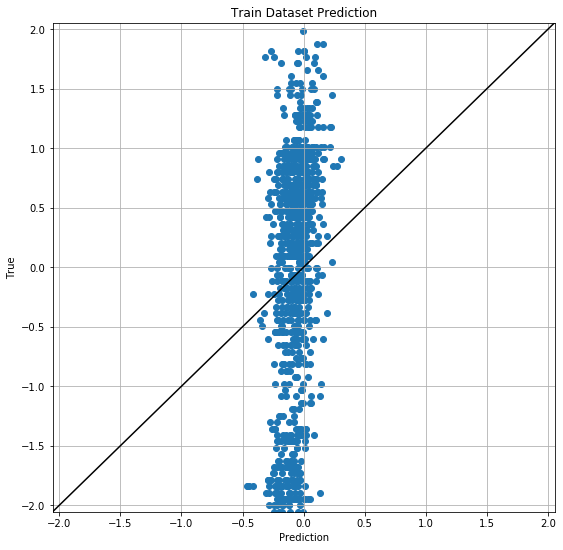

In [15]:
plot_result(train_true, train_pred, fname=fname)

### Test

In [16]:
model.eval()
test_true, test_pred = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(test_loader)):

        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x).to(device)

        test_pred.append(y_pred.to('cpu'))
        test_true.append(y.to('cpu'))

        del x, y, y_pred
        torch.cuda.empty_cache()

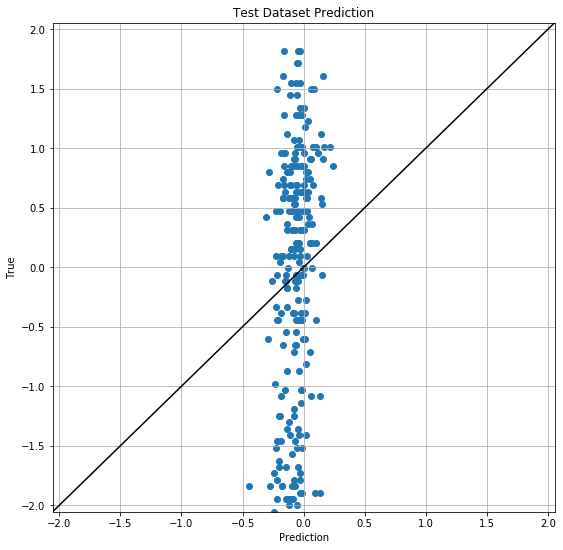

In [17]:
plot_result(test_true, test_pred, title='Test', fname=fname)

## Save Model

In [18]:
torch.save(model, f"./models/{fname}_model.pth")